# Assignment - Data Handling 4:

## Assignment Background:

This short assignment contains three sections of questions that build upon and incorporate methods, techniques and concepts taught and demonstrated in the lesson materials.

All questions aim to consider biological context. Timely submission will result in your assignment being returned within 14 days of the submission deadline. Marked Jupyter Notebook manuscripts will be returned with comments from your marker If you receive a pass or distinction, your marker will attach the model solutions for this assignment *via* the open pull request on your lesson's GitHub repository.

This assignment will build upon the lesson material by having you explore the brain activity data of a child at the start of an epileptic seizure. The trace shows **4 seconds** of evolution of the **first 10 channels** of a seizure rhythm at a sampling rate of 1024 per second (`sr=1024`).

**Note**: You are encouraged to copy code blocks / functions from the lesson material in order to help you complete this assignment.

## Assignment Questions:

## Question 1

**A.**

Using the CSV file, `P1_Seizure1.csv` from the [data](../data/) folder, complete the following questions.
- Read the CSV file into the notebook, and convert it into a NumPy array.

*To obtain your path in a Codespace or a local IDE such as Microsoft Visual Studio Code, navigate to the data file (in your Explorer pane on the left of the window), right click it, and click 'Copy path'. Paste this between quotes, and assign this to the 'path' variable instead.*

In [15]:
# Import statements:

from pandas import read_csv
from matplotlib.pyplot import subplots, yticks, legend, axis, show

from numpy import arange, linspace, zeros, around, corrcoef, fill_diagonal, triu_indices, mean, flip, median

from scipy.signal import butter, sosfilt

from scipy.fftpack import fft

In [16]:
path = './data/P1_Seizure1.csv'

data = read_csv(path, delimiter=r"\s+")
data_np = data.to_numpy()

**B.** 

Create a user-defined plotting function that satisfies the following:
- Properly formats the time series so that they don't overlap
- Generates appropriates axes and labels
*HINT: See the lesson materials for the function code*

In [17]:
def plot_series(data, sr):
    '''
    Time series plot of multiple time series
    Data are normalised to mean=0 and var=1 
    
    Parameters:
    -----------
    data : numpy.ndarray
        nxm numpy array. Rows are time points, columns are channels
    sr : int
        Sampling rate, same time units as period
    
    Features:
    ---------
    - Normalises each channel to mean=0, std=1
    - Offsets channels vertically for clear separation
    - Adds reference lines at zero for each channel
    - Proper time axis scaling
    - Channel labelling
    '''
    
    samples = data.shape[0]
    sensors = data.shape[1]
    
    period = samples // sr
    time = linspace(0, period, period*sr)
    
    offset = 5  # for mean=0 and var=1 normalised data

    # Calculate means and standard deviations of all columns
    means = data.mean(axis=0)
    stds = data.std(axis=0)

    # Plot normalised series with vertical offset of 5 units between channels
    
    fig, ax = subplots(figsize=(7, 8))

    # Plot normalised data with vertical offsets
    ax.plot(time, (data - means)/stds + offset*arange(sensors-1, -1, -1))

    # Add reference lines at zero for each channel
    ax.plot(time, zeros((samples, sensors)) + offset*arange(sensors-1, -1, -1), 
            '--', color='gray', alpha=0.5)
    
    ax.set(xlabel='Time (seconds)', ylabel='Channel')
    ax.set_yticks(offset*arange(sensors))
    ax.set_yticklabels(flip(arange(sensors)))
    
    return fig, ax

## Question 2

**A.**

Use your newly-defined function to plot the initial data. Make sure to:
- Only plot the first 4 seconds of data
- Only plot the first 10 channels

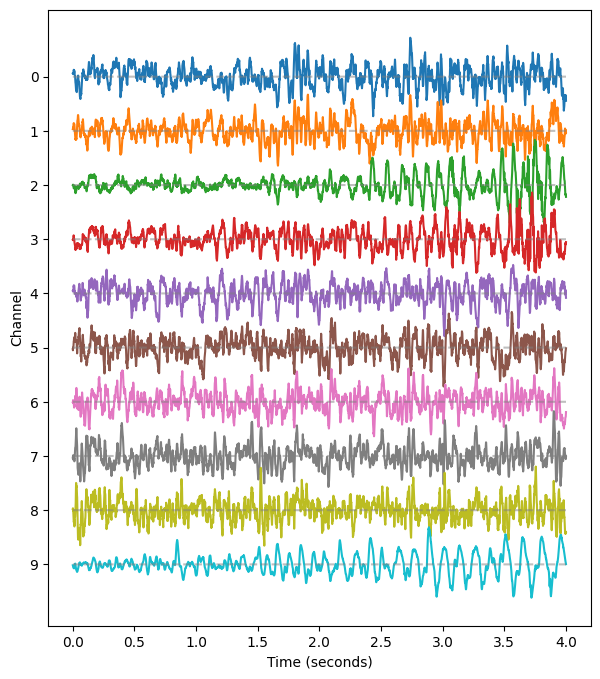

In [18]:
sr = 1024

period = 4

channels = 10

plot_series(data_np[:sr*period, :channels], sr);

show()

## Question 3

For these questions, we will generate an overview of uni- and multivariate features in the data, using the following approach.

**A.**

From the main dataset, extract two further, separate datasets:
- The first 2 seconds as background activity
- The last 2 seconds as epileptic seizure activity
- Extract only the first 10 channels for both datasets
- Print the `shape` of both datasets to verify they are correct: **(2028, 10)**

In [19]:
duration = 2 # seconds

dat_back = data_np[:duration*sr, :10]
dat_epil = data_np[data_np.shape[0] - duration*sr:, :10]

print(dat_back.shape, dat_epil.shape)

(2048, 10) (2048, 10)


**B.**

Create or use a function that contains the `scipy.signal.butter` function which utilises a `bandpass` filter with appropriate settings.
- *HINT: See the lesson material for the code.*
- Apply the filter to both datasets in order to remove frequencies **below 1 Hz** and **above 20 Hz**

In [20]:
def data_filter(data, sr, low, high):
    """
    Filtering of multiple time series.

    data: nxm numpy array. Rows are time points, columns are recordings
    sr: sampling rate, same time units as period

    low:  Low cut-off frequency (high-pass filter)
    high: High cut-off frequency (low-pass filter)

    return: filtered data
    """

    from scipy.signal import butter, sosfilt

    order = 5

    sos = butter(order, (low,high), btype='bandpass', fs=sr, output='sos')

    data_filtered = zeros((data.shape[0], data.shape[1]))

    for index, column in enumerate(data.transpose()):
        forward = sosfilt(sos, column)
        backwards = sosfilt(sos, forward[-1::-1])
        data_filtered[:, index] = backwards[-1::-1]

    return data_filtered

In [21]:
dat_back_filt = data_filter(dat_back, sr, 1, 20)
dat_epil_filt = data_filter(dat_epil, sr, 1, 20)

**C.**

Plot the filtered data:
- Use your plotting function to create separate plots for the filtered background and seizure datasets
- Use the `.suptitle` method on fig to appropriately title the plot

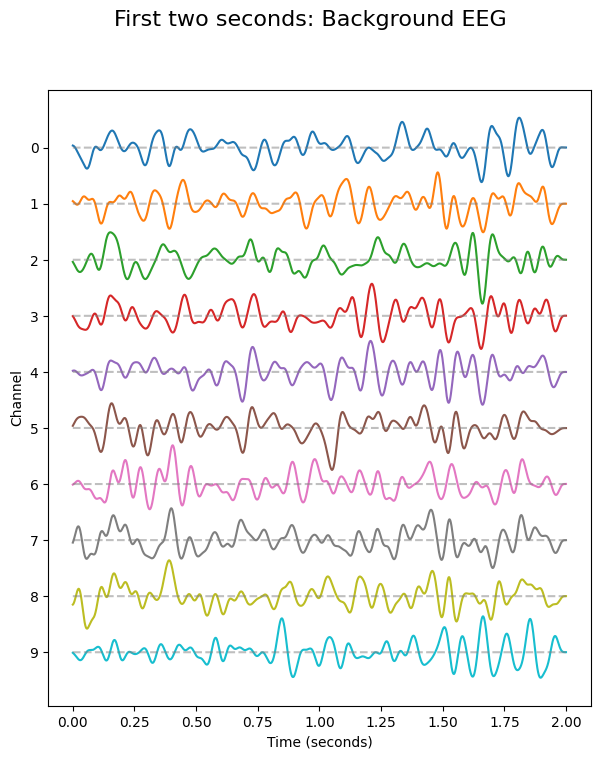

In [22]:
(fig, ax) = plot_series(dat_back_filt, sr)

fig.suptitle('First two seconds: Background EEG', fontsize=16);

show()

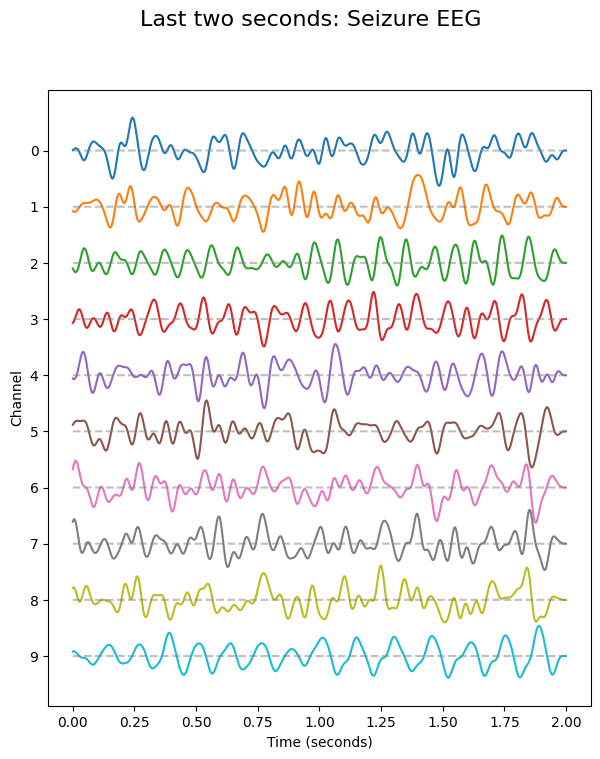

In [23]:
(fig, ax) = plot_series(dat_epil_filt, sr)

fig.suptitle('Last two seconds: Seizure EEG', fontsize=16);

show()

## Question 4

**A.**

Apply a Fourier Transform to both filtered datasets:
- Calculate the power/amplitude spectrum of the frequenices from the fourier transform
- Create a NumPy array containing the possible frequencies using `numpy.linspace`
- Create line plots displaying the Fourier spectra of the first 4 channels for each dataset
- Give each plot an appropriate title

In [24]:
rows = dat_back.shape[0]

dat_back_fft = fft(dat_back_filt, axis=0)
powers_back = (2.0 / rows) * abs(dat_back_fft[:rows//2, :])

dat_epil_fft = fft(dat_epil_filt, axis=0)
powers_epil = (2.0 / rows) * abs(dat_epil_fft[:rows//2, :])

In [25]:
freqs = (sr/2)*linspace(0, 1, int(rows/2))

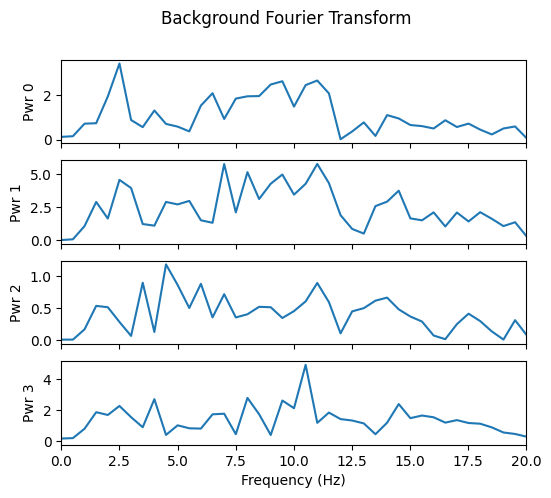

In [26]:
n_plots = 4

fig, axes = subplots(figsize=(6, 5), ncols=1, nrows=n_plots, sharex=True)

for index, ax in enumerate(axes.flat):
    axes[index].plot(freqs, powers_back[:, index])
    axes[index].set_xlim(0, 20)
    axes[index].set(ylabel=f'Pwr {index}')

axes[index].set(xlabel='Frequency (Hz)');
fig.suptitle('Background Fourier Transform')

show()

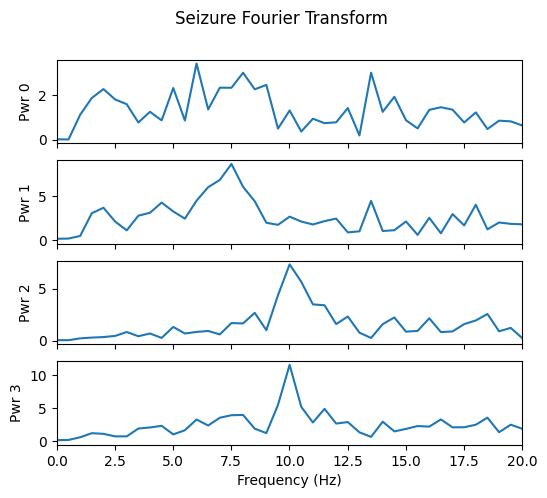

In [27]:
fig, axes = subplots(figsize=(6, 5), ncols=1, nrows=n_plots, sharex=True)

for index, ax in enumerate(axes.flat):
    axes[index].plot(freqs, powers_epil[:, index])
    axes[index].set_xlim(0, 20)
    axes[index].set(ylabel=f'Pwr {index}')

axes[index].set(xlabel='Frequency (Hz)');
fig.suptitle('Seizure Fourier Transform')

show()

**B.**

Find peak frequencies:
- Use NumPy's [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to get the indices of the maximum values in each column of your Fourier transform results.
- Use these indices to **extract the corresponding frequencies** from your frequency array *via* slicing
- Display a list of the maximum frequency per channel for each dataset (rounded to 1 decimal place)
- Round the items in the array to 1 decimal place. You can use NumPy's [`around`](https://numpy.org/doc/2.0/reference/generated/numpy.around.html) function to do this, as `round` will not work on an array.
- Calculate and display the median max frequency per dataset:
    - Use NumPy's `median` function
    - Use the rounded data
    - Do you observe a difference between the background and seizure datasets?

In [28]:
# Find the frequency index of maximum power for each channel
powermax_back_index = powers_back.argmax(axis=0)
powermax_epil_index = powers_epil.argmax(axis=0)

# Use indices to directly get the frequencies
powermax_back_freq = freqs[powermax_back_index]
powermax_epil_freq = freqs[powermax_epil_index]

print('Frequencies of max power in background (Hz):', around(powermax_back_freq, decimals=1))
print('Frequencies of max power in seizure (Hz):', around(powermax_epil_freq, decimals=1))

Frequencies of max power in background (Hz): [ 2.5 11.   4.5 10.5 10.5  1.5 10.5 10.5 10.5 11. ]
Frequencies of max power in seizure (Hz): [ 6.   7.5 10.  10.  12.   8.   3.5  7.   7.   8. ]


In [29]:
print('Median Frequency')

print('Background: ', median(around(powermax_back_freq, decimals=1)))

print('Seizure:    ', median(around(powermax_epil_freq, decimals=1)))

Median Frequency
Background:  10.5
Seizure:     7.75


## Question 5

**A.**

Generate correlation matrices
- Calculate the correlation matrix for *both* datasets
- Set the diagonal values to 0 (since self-correlation is always 1)
- Create side-by-side subplots showing both correlation matrices with appropriate titles and colour bars
- Ensure the colour scale is the set between -1 and 1 to allow for comparison

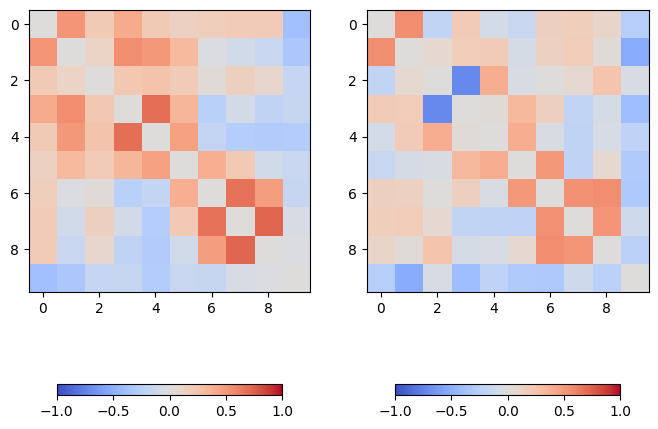

In [30]:
corr_matrix_back = corrcoef(dat_back_filt, rowvar=False)

fill_diagonal(corr_matrix_back, 0)

corr_matrix_epil = corrcoef(dat_epil_filt, rowvar=False)

fill_diagonal(corr_matrix_epil, 0)

fig, ax = subplots(figsize = (8,8), ncols=2)

im1 = ax[0].imshow(corr_matrix_back, cmap='coolwarm', vmin=-1, vmax=1);
fig.colorbar(im1, ax=ax[0], orientation='horizontal', shrink=0.8)
im2 = ax[1].imshow(corr_matrix_epil, cmap='coolwarm', vmin=-1, vmax=1);
fig.colorbar(im2, ax=ax[1], orientation='horizontal', shrink=0.8);

show()

**B.**

 Calculate mean correlations:
- Calculate the **mean correlation** (using absolute values) of each channel, per dataset
- Find the overall mean correlation values for each dataset:
   - Print your findings
   - How does the correlation differ between background and seizure activity?

*HINT: Look back at the Data Handling 2 lesson if you need a reminder on correlation analysis.*

In [31]:
cor_average_back = mean(abs(corr_matrix_back), axis=0)

cor_average_epil = mean(abs(corr_matrix_epil), axis=0)

In [32]:
print('Mean correlation per dataset:')

print('Background: ', mean(cor_average_back))
print('Seizure:    ', mean(cor_average_epil))

Mean correlation per dataset:
Background:  0.23247939448697377
Seizure:     0.20094137659526085
